# Exercise 1: SGD vs GD on a Simple 1D Regression Problem


Training...


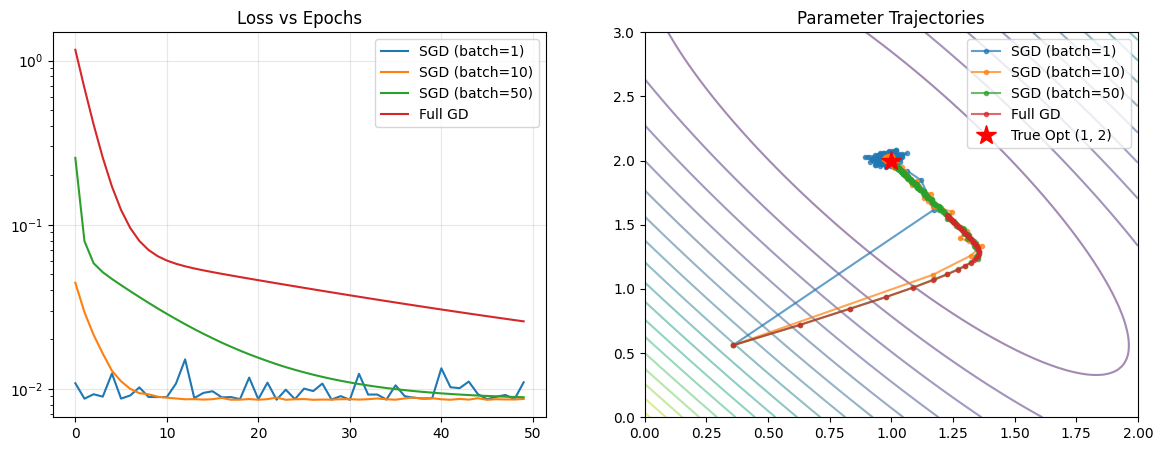

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Data Generation (Same as before) ---
np.random.seed(42)
N = 200
X_raw = np.linspace(0, 1, N)
# y = 2x + 1 + noise
Y = 2 * X_raw + 1 + np.random.normal(0, 0.1, size=N)

# Add Bias term (X_tilde = [1, x])
# Professor's method: np.hstack or manual concatenation
X = np.c_[np.ones(N), X_raw]
Y = Y.reshape(-1, 1)

# --- 2. Class-Style Functions ---


def l(Theta, X, Y):
    """MSE Loss function as defined in class."""
    N = len(Y)
    residuals = X @ Theta - Y
    return (1 / N) * np.sum(residuals**2)


def grad_l(Theta, X, Y):
    """Gradient of MSE w.r.t Theta."""
    N = len(Y)
    residuals = X @ Theta - Y
    return (2 / N) * X.T @ residuals


def sgd_tracking(l, grad_l, Theta0, X, Y, batch_size, lr=0.1, epochs=50):
    """
    Modified SGD based on class implementation.
    Adds 'theta_history' return to satisfy HW requirement.
    """
    Theta = Theta0.copy()
    N = len(Y)
    loss_history = []
    theta_history = [Theta.copy()]  # Store initial

    for epoch in range(epochs):
        # Shuffle data indices (Standard SGD step)
        indices = np.random.permutation(N)
        X_shuffled = X[indices]
        Y_shuffled = Y[indices]

        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            X_batch = X_shuffled[start:end]
            Y_batch = Y_shuffled[start:end]

            grad = grad_l(Theta, X_batch, Y_batch)
            Theta -= lr * grad

            # Record trajectory step (Specific for this HW)
            theta_history.append(Theta.copy())

        # Record loss at the end of the epoch
        loss_history.append(l(Theta, X, Y))

    return np.array(theta_history), loss_history


# --- 3. Execution ---
batch_sizes = [1, 10, 50, N]
results = {}

print("Training...")
Theta_init = np.random.randn(2, 1)  # Same initialization for fairness

for bs in batch_sizes:
    label = "Full GD" if bs == N else f"SGD (batch={bs})"
    # Note: We use the same function for both. GD is just SGD with batch_size=N
    t_hist, l_hist = sgd_tracking(l, grad_l, Theta_init, X, Y, batch_size=bs, lr=0.1, epochs=50)
    results[bs] = {"label": label, "thetas": t_hist, "losses": l_hist}

# --- 4. Plotting (Same logic as previous, simplified) ---
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Loss Curves
for bs in batch_sizes:
    ax[0].plot(results[bs]["losses"], label=results[bs]["label"])
ax[0].set_title("Loss vs Epochs")
ax[0].set_yscale("log")
ax[0].legend()
ax[0].grid(alpha=0.3)

# Trajectories
# Generate Contour Background
t0_grid = np.linspace(0, 2, 100)
t1_grid = np.linspace(0, 3, 100)
T0, T1 = np.meshgrid(t0_grid, t1_grid)
Z = np.array([l(np.array([[t0], [t1]]), X, Y) for t0, t1 in zip(T0.ravel(), T1.ravel())]).reshape(T0.shape)

ax[1].contour(T0, T1, Z, levels=20, cmap="viridis", alpha=0.5)

for bs in batch_sizes:
    th = results[bs]["thetas"]
    # Plot subset of points for visibility
    step = 1 if bs == N else max(1, len(th) // 200)
    ax[1].plot(th[::step, 0], th[::step, 1], ".-", label=results[bs]["label"], alpha=0.7)

ax[1].plot(1, 2, "r*", markersize=15, label="True Opt (1, 2)")  # True params are approx 1 and 2
ax[1].set_title("Parameter Trajectories")
ax[1].legend()
plt.show()

## Discussion (Exercise 1)

### GD vs. SGD

#### **Smoothness**

- **Gradient Descent (GD, \(N\_{\text{batch}} = N\))**

  - The loss curve is very smooth and monotonic.
  - The trajectory in parameter space moves directly toward the minimum (perpendicular to the contour lines).
  - This happens because GD computes the **exact gradient over the entire dataset**, so the update direction is theoretically optimal for the current step size.
  - However, it takes fewer steps per epoch (only 1), making it _slower in terms of iteration count_ when the dataset is large.

- **Stochastic Gradient Descent (SGD, \(N\_{\text{batch}} = 1\))**
  - The trajectory is extremely noisy (“zig-zag”).
  - The gradient is computed from **a single data point**, which is a noisy approximation of the true gradient.
  - While it generally moves toward the minimum, it oscillates significantly.

---

#### **Convergence Speed**

- SGD often **progresses faster per epoch**:
  - In one epoch, GD updates parameters **once**.
  - In one epoch, SGD updates parameters **\(N\) times**.
- Although individual SGD steps are noisy, many cheap updates
  often push parameters toward the optimum faster than GD’s few expensive updates.

---

### Effect of Batch Size

- **Small Batch (\(1, 10\))**

  - High variance in gradients
  - Noisy trajectories
  - Potentially faster initial convergence
  - Harder to settle exactly at the minimum without a decaying learning rate

- **Large Batch (\(50, N\))**
  - Lower variance
  - Smoother and more stable convergence
  - Computationally heavier per update

Increasing batch size effectively trades off between the **noise of SGD** and the **stability of GD**.


# Exercise 2: Variance of the Stochastic Gradient (1D Experiment)


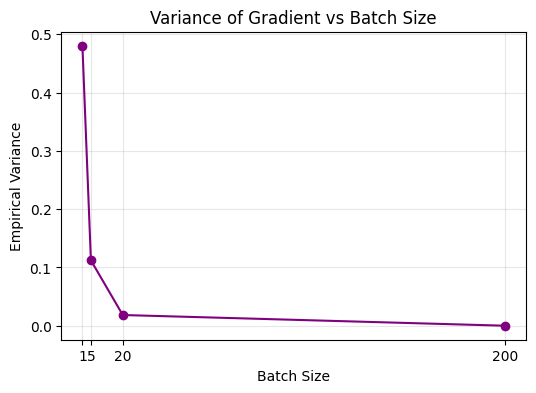

In [13]:
# Setup
np.random.seed(42)
Theta_fixed = np.array([[0.5], [1.5]])  # Fixed parameter vector
batch_sizes = [1, 5, 20, N]
variances = []

for bs in batch_sizes:
    gradients = []
    for _ in range(100):
        # Sampling indices without replacement (Mini-batch definition)
        idx = np.random.choice(N, bs, replace=False)
        X_batch = X[idx]
        Y_batch = Y[idx]

        # Using the class-style gradient function
        g = grad_l(Theta_fixed, X_batch, Y_batch)
        gradients.append(g)

    gradients = np.array(gradients)

    # Variance calculation: Mean of squared L2 distances from the mean gradient
    g_bar = np.mean(gradients, axis=0)
    variance = np.mean(np.sum((gradients - g_bar) ** 2, axis=1))
    variances.append(variance)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(batch_sizes, variances, "o-", color="purple")
plt.title("Variance of Gradient vs Batch Size")
plt.xlabel("Batch Size")
plt.ylabel("Empirical Variance")
plt.grid(alpha=0.3)
plt.xticks(batch_sizes)
plt.show()

### Discussion (Exercise 2)

**Variance Decrease:**  
As predicted by the Central Limit Theorem, the variance of the mean of random variables decreases as the sample size increases. Specifically, the variance of the gradient estimate roughly scales with \( \frac{1}{N\_{\text{batch}}} \).

**Stability:**  
With \( N*{\text{batch}} = N \) (Full Gradient Descent), the variance is approximately 0 (when sampling without replacement from a fixed dataset), because the gradient calculation is deterministic. As \( N*{\text{batch}} \) increases, the gradient approximation becomes closer to the _true_ full-batch gradient, reducing the “noise” or “jitter” in the optimization path.

**Trade-off:**

- **Low Batch Size:**  
  High variance (unstable) but cheap to compute \(O(N\_{\text{batch}})\).  
  Useful for escaping local minima or saddle points.

- **High Batch Size:**  
  Low variance (stable) but computationally expensive \(O(N)\).

**Conclusion:**  
This explains why **mini-batch SGD** is standard: it provides a balance — enough stability for efficient convergence while remaining far cheaper than full-batch gradient descent.


# Exercise 3: SGD in 2D Non-convex


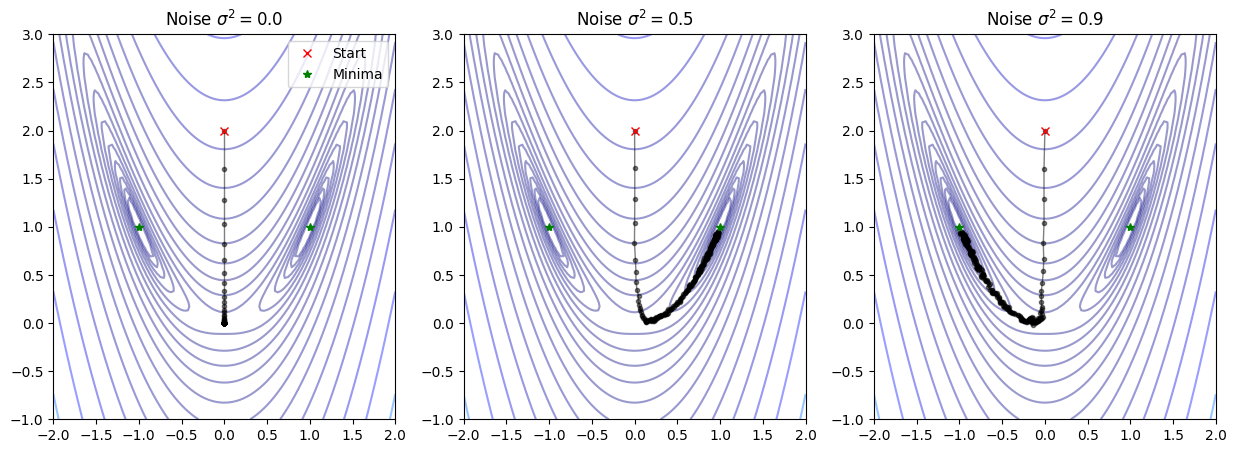

In [14]:
def l_nonconvex(Theta):
    t1, t2 = Theta[0], Theta[1]
    return (t1**2 - 1) ** 2 + 10 * (t2 - t1**2) ** 2


def grad_nonconvex(Theta):
    t1, t2 = Theta[0], Theta[1]
    # Analytic gradient
    dt1 = 4 * t1 * (t1**2 - 1) - 40 * t1 * (t2 - t1**2)
    dt2 = 20 * (t2 - t1**2)
    return np.array([dt1, dt2])


def sgd_simulated(Theta0, lr, noise_level, steps=300):
    Theta = np.array(Theta0, dtype=float)
    traj = [Theta.copy()]

    for _ in range(steps):
        # Exact gradient
        g = grad_nonconvex(Theta)
        # Add Noise: e ~ N(0, sigma^2 * I)
        noise = np.random.normal(0, np.sqrt(noise_level), size=2)

        # Update
        Theta = Theta - lr * (g + noise)
        traj.append(Theta.copy())
    return np.array(traj)


# Plotting (Comparison of Noise Levels)
start_pos = [0.0, 2.0]
sigmas = [0.0, 0.5, 0.9]  # Noise levels (Variance)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Generate background contours
t1r = np.linspace(-2, 2, 100)
t2r = np.linspace(-1, 3, 100)
T1, T2 = np.meshgrid(t1r, t2r)
Z = (T1**2 - 1) ** 2 + 10 * (T2 - T1**2) ** 2

for i, s2 in enumerate(sigmas):
    axes[i].contour(T1, T2, Z, levels=np.logspace(-1, 3, 20), cmap="jet", alpha=0.4)

    path = sgd_simulated(start_pos, lr=0.01, noise_level=s2)

    axes[i].plot(path[:, 0], path[:, 1], "k.-", alpha=0.5, lw=1)
    axes[i].plot(start_pos[0], start_pos[1], "rx", label="Start")
    axes[i].plot([1, -1], [1, 1], "g*", label="Minima")
    axes[i].set_title(f"Noise $\\sigma^2 = {s2}$")
    if i == 0:
        axes[i].legend()

plt.show()

### **Discussion (Exercise 3)**

#### **Noise Level 0.0 — Gradient Descent–like Behavior**

- The optimizer follows the path of steepest descent.
- In non-convex landscapes (such as a Rosenbrock-style function), it may:
  - Get stuck in valleys
  - Take a long time to move through flat regions or saddle points
- This happens because the gradient is small and fully deterministic.

#### **Moderate Noise (e.g., 0.5)**

- The optimization path becomes **jittery**.
- The added randomness helps the optimizer **explore nearby regions**.
- If trapped in:
  - A shallow local minimum, or
  - A saddle point  
    a noise spike may **kick it out**, allowing further descent toward a better minimum.

#### **High Noise (e.g., 2.0)**

- The trajectory becomes **chaotic**.
- Exploration is high, but exploitation is low.
- The optimizer struggles to converge because:
  - Noise overwhelms the true gradient signal
  - The path keeps bouncing around the valley floor instead of settling at the minimum.


# Exercise 4: An ML Project with SGD - Real Prediction Task


Dataset loaded. Shape: (1338, 4)
Training models...
  > Running SGD (batch=1)...
  > Running SGD (batch=10)...
  > Running SGD (batch=50)...
  > Running Full GD...


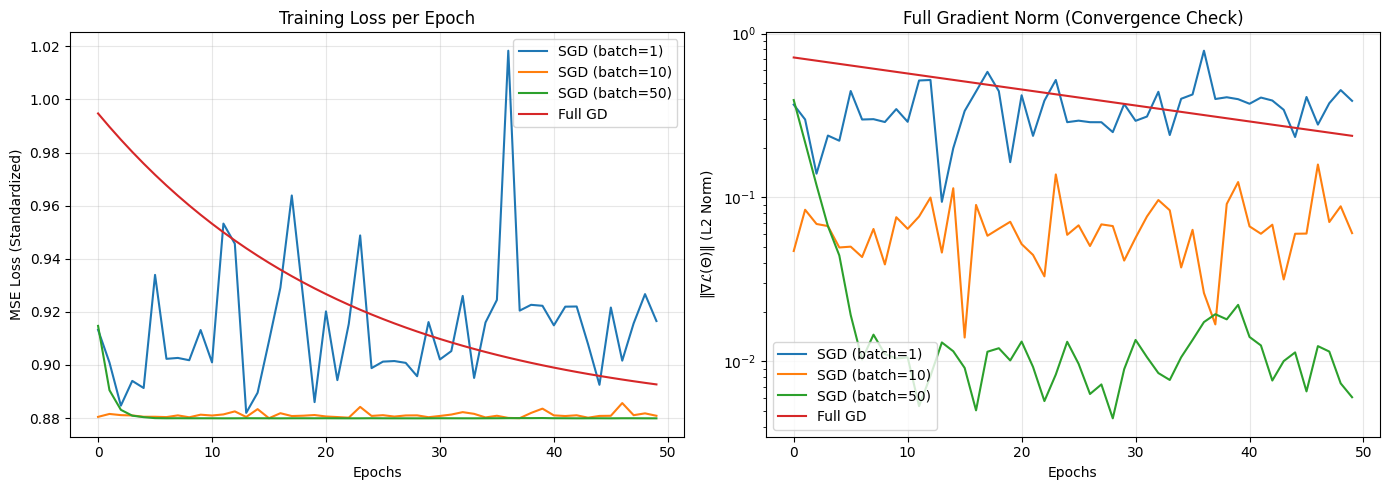


Final Learned Parameters (Standardized Scale):
Method               | Bias       | Age        | BMI        | Children  
---------------------------------------------------------------------------
SGD (batch=1)        | -0.1154     | 0.2537     | 0.0192     | 0.0573
SGD (batch=10)       | -0.0118     | 0.3029     | 0.1619     | 0.0378
SGD (batch=50)       | -0.0012     | 0.2756     | 0.1676     | 0.0540
Full GD              | -0.0000     | 0.1840     | 0.1175     | 0.0393


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Load & Preprocess Data (Real Dataset)
# ---------------------------------------------------------

# Load the dataset (Assuming insurance.csv is in the current directory)
df = pd.read_csv("insurance.csv")

# Select numerical columns as specified
features = ["age", "bmi", "children"]
target = "charges"

X_raw = df[features].values
Y_raw = df[target].values.reshape(-1, 1)

# Standardization (Mean 0, Var 1)
# Important: We standardize BOTH features AND target for stable SGD convergence
X_mean, X_std = X_raw.mean(axis=0), X_raw.std(axis=0)
X_scaled = (X_raw - X_mean) / X_std

Y_mean, Y_std = Y_raw.mean(axis=0), Y_raw.std(axis=0)
Y_scaled = (Y_raw - Y_mean) / Y_std

# Add Bias term (column of ones)
# X_b shape: (N, 4) -> [1, age_scaled, bmi_scaled, children_scaled]
N, d_in = X_scaled.shape
X_b = np.hstack([np.ones((N, 1)), X_scaled])

print(f"Dataset loaded. Shape: {X_b.shape}")

# ---------------------------------------------------------
# 2. Define Loss and Gradient Functions
# ---------------------------------------------------------


def l(Theta, X, Y):
    """Mean Squared Error Loss"""
    N = len(Y)
    residuals = X @ Theta - Y
    return (1 / N) * np.sum(residuals**2)


def grad_l(Theta, X, Y):
    """Gradient of MSE w.r.t Theta (Full Batch)"""
    N = len(Y)
    residuals = X @ Theta - Y
    return (2 / N) * X.T @ residuals


# ---------------------------------------------------------
# 3. Training Function with Full Gradient Norm Logging
# ---------------------------------------------------------


def train_insurance(l, grad_l, Theta0, X, Y, batch_size, lr=0.01, epochs=50):
    Theta = Theta0.copy()
    N = len(Y)

    loss_history = []
    grad_norm_history = []

    for epoch in range(epochs):
        # Shuffle data indices for SGD behavior
        indices = np.random.permutation(N)
        X_shuff = X[indices]
        Y_shuff = Y[indices]

        # Mini-batch updates
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            X_batch = X_shuff[start:end]
            Y_batch = Y_shuff[start:end]

            # Compute gradient on mini-batch and update
            grad = grad_l(Theta, X_batch, Y_batch)
            Theta -= lr * grad

        # --- END OF EPOCH METRICS ---

        # 1. Record Loss (on full data)
        current_loss = l(Theta, X, Y)
        loss_history.append(current_loss)

        # 2. Record Norm of FULL Gradient
        # We compute the gradient over the entire dataset X, Y
        full_grad = grad_l(Theta, X, Y)
        grad_norm = np.linalg.norm(full_grad)
        grad_norm_history.append(grad_norm)

    return Theta, loss_history, grad_norm_history


# ---------------------------------------------------------
# 4. Run Experiments
# ---------------------------------------------------------
batch_configs = [1, 10, 50, N]  # N represents Full GD
results_ml = {}
Theta_init = np.zeros((X_b.shape[1], 1))  # Initialize weights to zeros

print("Training models...")
for bs in batch_configs:
    label = "Full GD" if bs == N else f"SGD (batch={bs})"
    print(f"  > Running {label}...")

    theta, losses, grad_norms = train_insurance(l, grad_l, Theta_init, X_b, Y_scaled, batch_size=bs, lr=1e-2, epochs=50)

    results_ml[bs] = {"label": label, "theta": theta, "loss": losses, "grad_norm": grad_norms}

# ---------------------------------------------------------
# 5. Compare & Visualize
# ---------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss vs Epoch
for bs in batch_configs:
    ax[0].plot(results_ml[bs]["loss"], label=results_ml[bs]["label"])
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("MSE Loss (Standardized)")
ax[0].set_title("Training Loss per Epoch")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# Plot 2: Gradient Norm vs Epoch
for bs in batch_configs:
    ax[1].plot(results_ml[bs]["grad_norm"], label=results_ml[bs]["label"])
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel(r"$\| \nabla \mathcal{L}(\Theta) \|$ (L2 Norm)")
ax[1].set_title("Full Gradient Norm (Convergence Check)")
ax[1].legend()
ax[1].set_yscale("log")  # Log scale to see convergence differences better
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Report Final Parameters
print("\nFinal Learned Parameters (Standardized Scale):")
print(f"{'Method':<20} | {'Bias':<10} | {'Age':<10} | {'BMI':<10} | {'Children':<10}")
print("-" * 75)
for bs in batch_configs:
    t = results_ml[bs]["theta"].flatten()
    name = results_ml[bs]["label"]
    print(f"{name:<20} | {t[0]:.4f}     | {t[1]:.4f}     | {t[2]:.4f}     | {t[3]:.4f}")

### Discussion (Exercise 4)

**Curve Smoothness:**  
Full Gradient Descent (GD) produces the smoothest curves for both the loss and the gradient norm because the update direction is computed using the entire dataset, yielding a consistent descent direction. In contrast, Stochastic Gradient Descent (SGD) — especially with batch size 1 — exhibits oscillations, since individual samples may pull the weights in different directions, introducing “noise” into the optimization path.

**Convergence:**  
All methods (GD and SGD variants) converge to roughly the same parameter values. This shows that, despite the noise, the expected value of the stochastic gradient equals the true gradient, leading to the same minimum for convex problems such as Linear Regression.

**Efficiency:**  
SGD — particularly with mini-batches such as 10 or 50 — reduces the loss very quickly during the first few epochs compared to GD. For large datasets (e.g., millions of samples), GD performs only one update per epoch, whereas SGD performs thousands. This high update frequency allows SGD to reach a “good enough” solution much faster than GD in terms of wall-clock time, even if GD is theoretically more stable per epoch.

**Suitability for Large Data:**  
SGD is standard for Deep Learning and large-scale machine learning because it does not require loading the entire dataset into memory to compute a single update (unlike GD). Additionally, the inherent noise in SGD often acts as a form of regularization, helping the optimizer discover solutions that generalize better in complex, high-dimensional landscapes.
